In [1]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD
from time import time
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib, os, math

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.Prepare data

In [2]:
from time import time
import numpy as np

start_time = time()

print('Loading X_train...')
X_train = np.load('/home/zxt/data/224/5k/X_train_224.npy')


end_time = time()
print('Running time: %s seconds'%(end_time - start_time))

Loading X_train...
Running time: 670.9636161327362 seconds


In [4]:
len(X_train)

70000

In [5]:
from time import time
import numpy as np

start_time = time()

print('Loading X_validate...')
X_validate = np.load('/home/zxt/data/224/5k/X_validate_224.npy')

print('Loading X_test...')
X_test = np.load('/home/zxt/data/224/5k/X_test_224.npy')
print('Loading labels...')
Y_train = np.load('/home/zxt/data/224/5k/Y_train_224.npy')
Y_validate = np.load('/home/zxt/data/224/5k/Y_validate_224.npy')
Y_test = np.load('/home/zxt/data/224/5k/Y_test_224.npy')

end_time = time()
print('Running time: %s seconds'%(end_time - start_time))

Loading X_validate...
Loading X_test...
Loading labels...
Running time: 287.6727795600891 seconds


In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (70000, 224, 224, 3)
70000 train samples
21000 validate samples
9000 test samples


In [7]:
X_train /=255.
X_validate /=  255.
X_test /= 255.

In [8]:
# Y_train label
for i in Y_train:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [9]:
for i in Y_validate:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [11]:
# one-hot encoder[only accpet int]
Y_train=np_utils.to_categorical(Y_train,20)
Y_validate=np_utils.to_categorical(Y_validate,20)
Y_test=np_utils.to_categorical(Y_test,20)

In [12]:
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 2.Model structure

In [13]:
def alexnet(input_shape, n_classes):
    input = Input(input_shape)
  
    # actually batch normalization didn't exist back then
    # they used LRN (Local Response Normalization) for regularization
    x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4096, activation='relu')(x)
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [14]:
# prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

### 3.Modeling

In [15]:
num_train_samples = len(Y_train)
num_val_samples = len(Y_validate)
batch_size = 128
epochs = 200
n_classes = 20
input_shape = 224,224,3

In [16]:
K.clear_session()
model = alexnet(input_shape, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0   

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [19]:
hist = model.fit(
    X_train, 
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data = (X_validate,Y_validate))

Train on 70000 samples, validate on 21000 samples
Epoch 1/200
70000/70000 [==============================] - 373s 5ms/step - loss: 1.5817 - accuracy: 0.4765 - val_loss: 1.5695 - val_accuracy: 0.4614
Epoch 2/200
70000/70000 [==============================] - 344s 5ms/step - loss: 1.0918 - accuracy: 0.6217 - val_loss: 1.2417 - val_accuracy: 0.5769
Epoch 3/200
70000/70000 [==============================] - 345s 5ms/step - loss: 0.9187 - accuracy: 0.6821 - val_loss: 2.0832 - val_accuracy: 0.4111
Epoch 4/200
70000/70000 [==============================] - 343s 5ms/step - loss: 0.7762 - accuracy: 0.7321 - val_loss: 0.8855 - val_accuracy: 0.6891
Epoch 5/200
70000/70000 [==============================] - 343s 5ms/step - loss: 0.6636 - accuracy: 0.7707 - val_loss: 0.7651 - val_accuracy: 0.7388
Epoch 6/200
70000/70000 [==============================] - 343s 5ms/step - loss: 0.5637 - accuracy: 0.8046 - val_loss: 0.7281 - val_accuracy: 0.7528
Epoch 7/200
70000/70000 [==============================]

In [23]:
model.save('/home/zxt/data/model/alex_5k_224_dp01.h5')

### 4.Evaluation

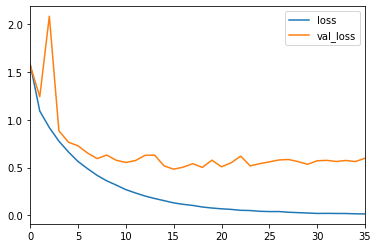

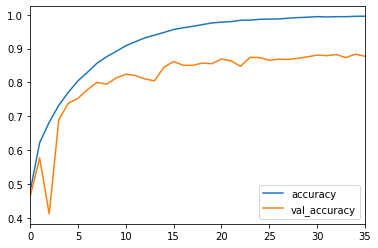

In [24]:
history_df = pd.DataFrame(hist.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()


### 5.Prediction on X_test dataset

In [25]:
loss,accuracy = model.evaluate(X_test,Y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

9000/9000 [==============================] - 18s 2ms/step

test loss 0.6106144201888496
accuracy 0.8805555701255798


In [26]:
y_pred = model.predict(X_test,batch_size=1)

1.0

In [41]:
a = list(y_pred)

In [43]:
yy=[]
for i in a:
    j =list(i)
    yy.append(j.index(max(j)))

In [45]:
yy[:5]

[9, 19, 15, 15, 9]

In [46]:
yy_real = np.load('/home/zxt/data/224/5k/Y_test_224.npy')

In [50]:
len(yy_real)

9000

In [51]:
for i in yy_real:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [52]:
yy_real

array([['9'],
       ['19'],
       ['15'],
       ...,
       ['2'],
       ['18'],
       ['0']], dtype='<U16')

In [54]:
yy[:3]

[9, 19, 15]

In [62]:
# array to dataframe
yy_real1=pd.DataFrame(yy_real,columns=['label'])

In [63]:
yy_real1.head()

,label
0,9
1,19
2,15
3,15
4,9


In [69]:
yy1 = pd.DataFrame(yy,columns=['label_pre'])

In [70]:
yy1.head()

,label_pre
0,9
1,19
2,15
3,15
4,9


In [74]:
y_pre = yy1

In [75]:
y = yy_real1

In [76]:
prediction_df = pd.concat([y,y_pre],axis=1)

In [82]:
prediction_df['label']=prediction_df['label'].astype(int)
prediction_df['diff']=prediction_df['label']-prediction_df['label_pre']

In [87]:
prediction_df.to_csv(r'/home/zxt/data/prediction_df.csv',index=False)

In [86]:
prediction_df[prediction_df['diff']!=0]

,label,label_pre,diff
20,14,18,-4
21,18,14,4
47,1,7,-6
57,19,1,18
60,0,11,-11
...,...,...,...
8966,8,15,-7
8970,7,3,4
8975,17,2,15
8981,0,10,-10
